In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

 In addition, the image color values are normalized to the `[0,1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits.

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [8]:
# class Augment(tf.keras.layers.Layer):
#   def __init__(self, seed=42):
#     super().__init__()
#     # both use the same seed, so they'll make the same random changes.
#     self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
#   def call(self, inputs, labels):
#     inputs = self.augment_inputs(inputs)
#     labels = self.augment_labels(labels)
#     return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset.

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
#     print(display_list[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


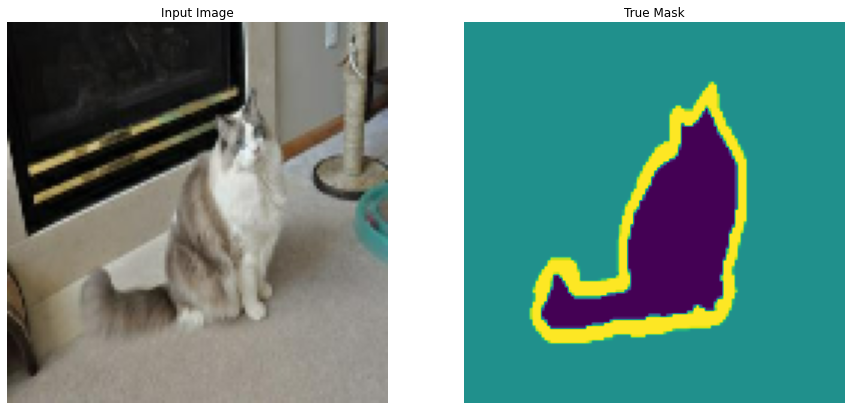

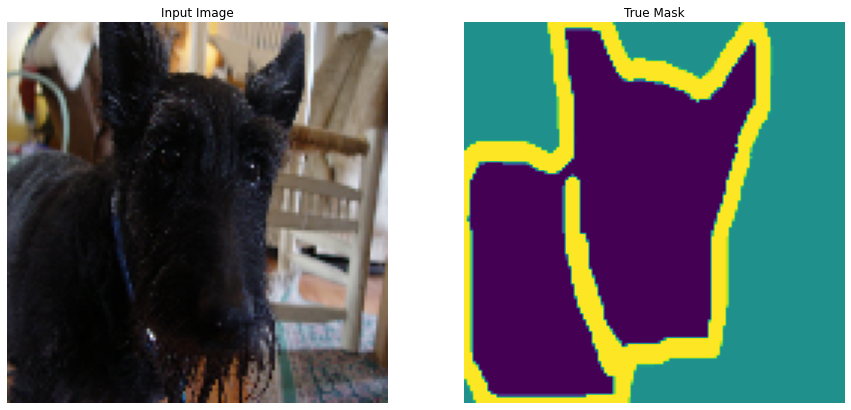

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [12]:
def unet(dim, output_neurons, output_activation):
    
    def conv_block(input, n_filters, d_strides=1):
        x = DepthwiseConv2D(kernel_size = (3,3), strides = d_strides, padding = 'same')(input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters = n_filters, kernel_size = (1,1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        return x

    def encoder_block(input, n_filters):
        x = conv_block(input, n_filters)
        x = conv_block(x, n_filters)
        p = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
        return x,p

    def decoder_block(input, concat_layer, n_filters):
        x = Conv2DTranspose(n_filters, kernel_size = (2,2), strides=2, padding = 'same')(input)
        x = Concatenate()([x, concat_layer])
        x = conv_block(x, n_filters)
        x = conv_block(x, n_filters)
        return x

    inputs = Input(shape = dim)
    
    k = 16
    
    s1, p1 = encoder_block(inputs, k)
    s2, p2 = encoder_block(p1, 2*k)
    s3, p3 = encoder_block(p2, 4*k)
    s4, p4 = encoder_block(p3, 8*k)

    b1 = conv_block(p4, 16*k)

    d1 = decoder_block(b1, s4, 8*k)
    d2 = decoder_block(d1, s3, 4*k)
    d3 = decoder_block(d2, s2, 2*k)
    d4 = decoder_block(d3, s1, k)

    outputs = Conv2D(output_neurons, kernel_size = (1,1), padding='same', activation = output_activation)(d4)

    model = Model(inputs = inputs, outputs = outputs, name='Modified-U-Net')

    return model

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class. 

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [13]:
output_neurons = 3
output_activation = 'softmax'
dim = (128,128,3)

model = unet(dim, output_neurons, output_activation)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

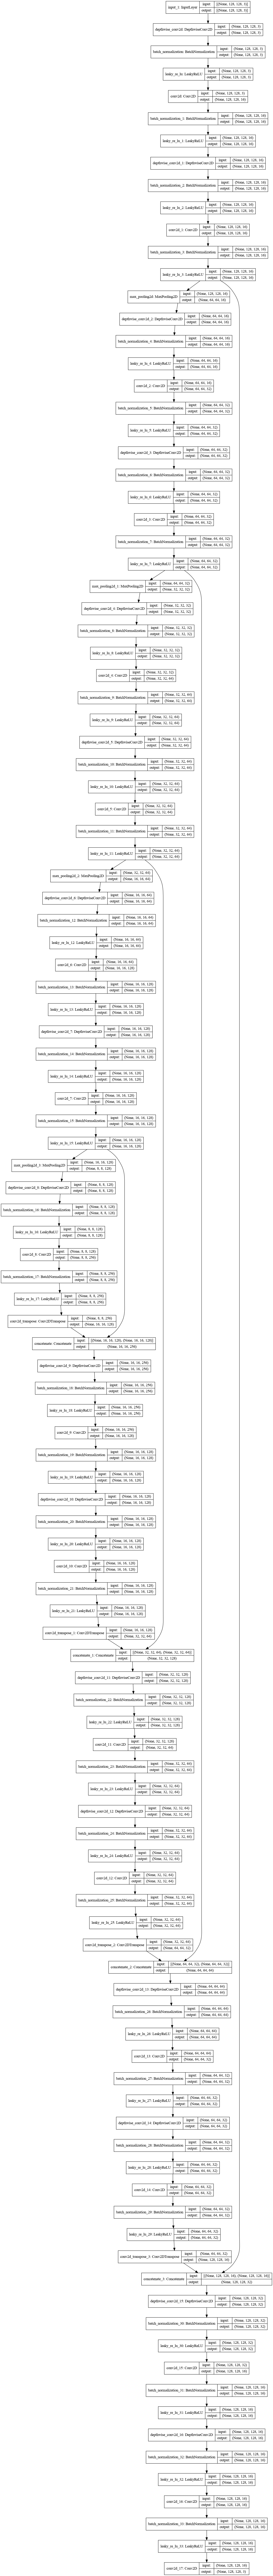

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training.

In [15]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [16]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

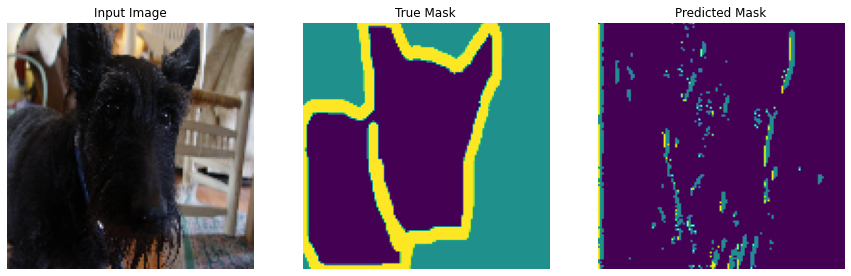

In [17]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training.

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

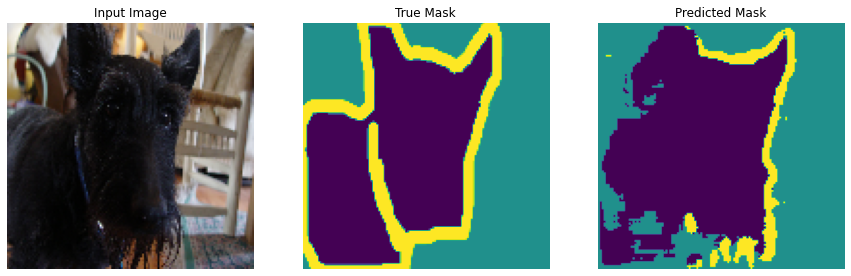


Sample Prediction after epoch 20



In [19]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

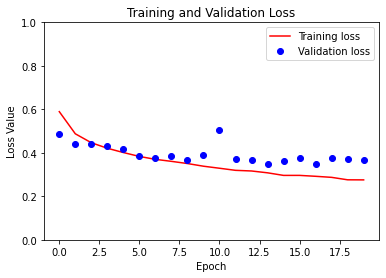

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

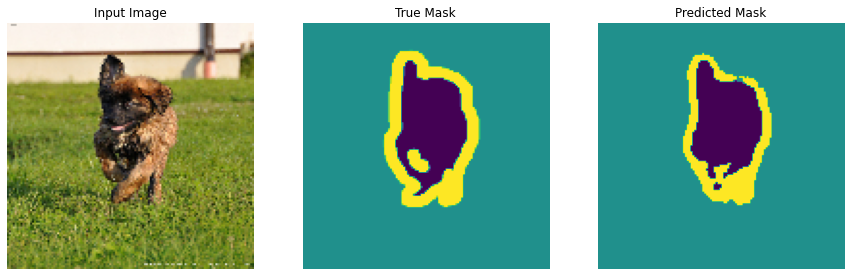

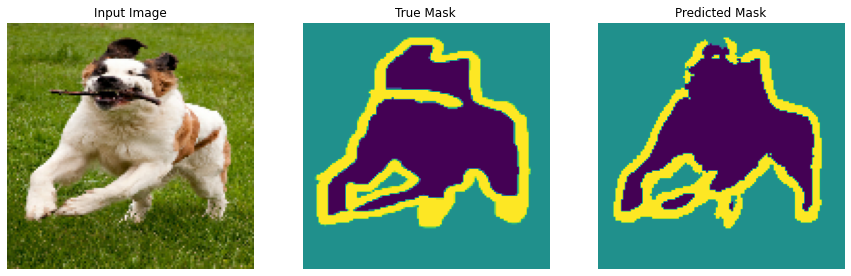

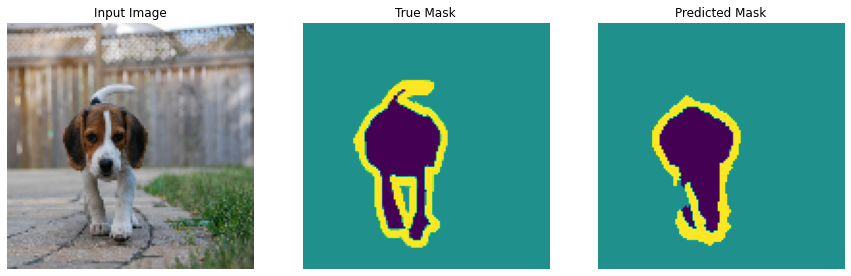

In [21]:
show_predictions(test_batches, 3)

In [22]:
model.summary()

Model: "Modified-U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 128, 128, 3)  30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          depthwise_conv2d[0][0]           
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 3)  0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [24]:
model.save('modified_unet')

INFO:tensorflow:Assets written to: modified_unet/assets


INFO:tensorflow:Assets written to: modified_unet/assets
